In [128]:
import sys
sys.path.append('../')

from stepselector.data_loader import ZebraDataset, ZebraBatchSampler, custom_collate
from torch.utils.data import Dataset, DataLoader, Sampler
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from concurrent.futures import ThreadPoolExecutor, as_completed
import os
import joblib
from osgeo import gdal
from tqdm.notebook import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

gdal.UseExceptions()

In [188]:
# Change server_mount for your system
server_mount = '/home/blair/server/herd_hover'
data_folder = os.path.join(server_mount, 'zebra_movement_data')

# Import pre-loaded data
data_file = os.path.join(data_folder, 'loaded_data_10msteps.csv')
data = pd.read_csv(data_file)
data.drop(labels = ['Unnamed: 0'], axis = 1, inplace = True)
data.rename(columns={'0': 'target_id',
                     '1': 'angle_to_observer',
                     '2': 'dist_to_observer',
                     '3': 'delta_observer_dist',
                     '4': 'road',
                     '5': 'ground_slope',
                     '6': 'visibility',
                     '7': 'social_dens',
                     '8': 'social_vis'}, inplace = True)

In [189]:
# Check if there are missing data
data.isna().any()

target_id              False
angle_to_observer      False
dist_to_observer       False
delta_observer_dist    False
road                   False
ground_slope           False
visibility             False
social_dens            False
social_vis             False
label                  False
dtype: bool

In [190]:
# If no NANs, drop the id column
data.drop(labels = ['target_id'], axis = 1, inplace = True)

In [191]:
# # impute missing values if there are any
# imputer = SimpleImputer(strategy = 'mean')
# df = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
# df = df_imputed.astype({'road': 'int32', 'social_dens':'int32', 'label':'int32'})

In [192]:
# Log-transform distances
data['log_dist_to_observer'] = np.log1p(data['dist_to_observer'])

# convert angles to sines and cosines
data['sin_angle_to_observers'] = np.sin(np.deg2rad(data['angle_to_observer']))
data['cos_angle_to_observers'] = np.cos(np.deg2rad(data['angle_to_observer']))
data['sin_ground_slope'] = np.sin(np.deg2rad(data['ground_slope']))
data['cos_ground_slope'] = np.cos(np.deg2rad(data['ground_slope']))

# drop untransformed columns
data = data.drop(columns =['dist_to_observer', 'angle_to_observer', 'ground_slope'])

In [193]:
# initialize scalers

# visibility is a proportion between 0 and 1
visibility_scaler = MinMaxScaler(feature_range=(0,1))

# social scaler used for counts of visible neighbors (social_vis) and neighbors within 10m (social_dens)
social_scaler = MinMaxScaler(feature_range=(0,1))

# log_distance scaler used for transformed distance to observers, and delta distance to observer
dist_scaler = StandardScaler()

# sin_cos_scaler used for transformed angles (ground_slope and angle_to_observer)
sin_cos_scaler = StandardScaler()

In [194]:
# apply scalers
#df['ground_slope'] = slope_scaler.fit_transform(df[['ground_slope']])
data['visibility'] = visibility_scaler.fit_transform(data[['visibility']])
data['social_dens'] = social_scaler.fit_transform(data[['social_dens']])
data['social_vis'] = social_scaler.fit_transform(data[['social_vis']])
data['log_dist_to_observer'] = dist_scaler.fit_transform(data[['log_dist_to_observer']])
data['delta_observer_dist'] = dist_scaler.fit_transform(data[['delta_observer_dist']])
data[['sin_angle_to_observers', 'cos_angle_to_observers', 'sin_ground_slope', 'cos_ground_slope']] = sin_cos_scaler.fit_transform(data[['sin_angle_to_observers', 'cos_angle_to_observers', 'sin_ground_slope', 'cos_ground_slope']])

In [195]:
# Choose your fighters
data = data[['delta_observer_dist', 
                   'road', 
                   'visibility', 
                   'social_dens', 
                   'social_vis', 
                   'log_dist_to_observer', 
                   'sin_angle_to_observers',
                   'cos_angle_to_observers',
                   'sin_ground_slope', 
                   'cos_ground_slope', 
                   'label']]

In [196]:
X = data.drop(columns='label')
y = data['label']

In [197]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [198]:
# Initialize and train the logistic regression model with parallelization
model = LogisticRegression(max_iter=1000, n_jobs=1, verbose=True, class_weight = 'balanced', penalty = None, C=1.0)  # n_jobs=-1 uses all available cores
model.fit(X_train, y_train)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  3.59491D-02

At iterate   50    f=  6.83792D-01    |proj g|=  1.42647D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     51     56      1     0     0   1.437D-05   6.838D-01
  F =  0.68379209651208606     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=1,
                   penalty=None, verbose=True)

In [199]:
# Make predictions on the train set
y_pred = model.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(y_train, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.55


In [200]:
# Print classification report
print("Classification Report:")
print(classification_report(y_train, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.55      0.67     14941
           1       0.20      0.56      0.29      3006

    accuracy                           0.55     17947
   macro avg       0.53      0.55      0.48     17947
weighted avg       0.75      0.55      0.61     17947



In [201]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.54


In [202]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.54      0.66      3754
           1       0.18      0.53      0.27       733

    accuracy                           0.54      4487
   macro avg       0.52      0.54      0.47      4487
weighted avg       0.75      0.54      0.60      4487



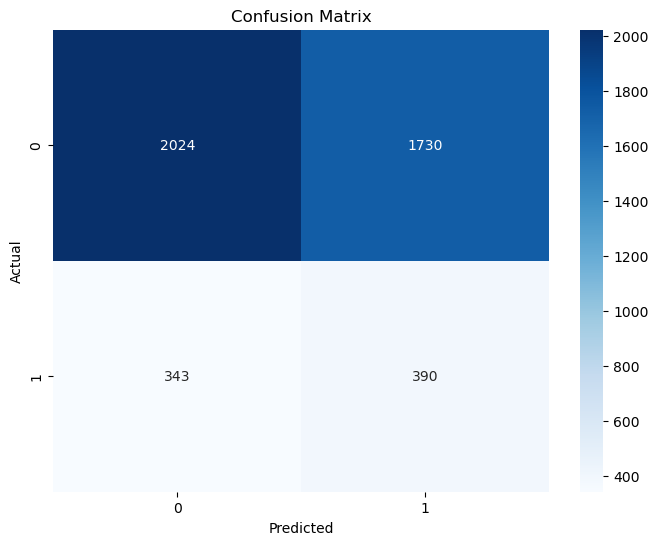

In [203]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [204]:
# Check coefficients
coefficients = model.coef_
intercept = model.intercept_
print("Model Coefficients:")
print(coefficients)
print("Model Intercept:")
print(intercept)

Model Coefficients:
[[ 0.79749041  0.19282073  0.18180063  1.0362193  -0.06083858 -0.14593827
   0.0513544   0.62138037  0.12486286  0.05671626]]
Model Intercept:
[-0.28822327]


In [205]:
# check for multicolinnearity 
vif_data = pd.DataFrame()
vif_data['feature'] = data.columns
vif_data['VIF'] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
vif_data

,feature,VIF
0,delta_observer_dist,328.923121
1,road,1.033875
2,visibility,4.868399
3,social_dens,3.054151
4,social_vis,5.892342
5,log_dist_to_observer,1.271036
6,sin_angle_to_observers,1.318802
7,cos_angle_to_observers,332.761863
8,sin_ground_slope,1.187211
9,cos_ground_slope,1.127811


In [206]:
# Try with MLPClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

clf = MLPClassifier(random_state=1, max_iter=1000, verbose = True, hidden_layer_sizes=(128,128,128)).fit(X_train, y_train)

Iteration 1, loss = 0.45913064
Iteration 2, loss = 0.44649613
Iteration 3, loss = 0.44453125
Iteration 4, loss = 0.44400475
Iteration 5, loss = 0.44319391
Iteration 6, loss = 0.44190303
Iteration 7, loss = 0.44065311
Iteration 8, loss = 0.44081228
Iteration 9, loss = 0.44013194
Iteration 10, loss = 0.43934028
Iteration 11, loss = 0.43854241
Iteration 12, loss = 0.43715181
Iteration 13, loss = 0.43885366
Iteration 14, loss = 0.43615078
Iteration 15, loss = 0.43632894
Iteration 16, loss = 0.43545209
Iteration 17, loss = 0.43515323
Iteration 18, loss = 0.43487466
Iteration 19, loss = 0.43351857
Iteration 20, loss = 0.43308326
Iteration 21, loss = 0.43325838
Iteration 22, loss = 0.43394706
Iteration 23, loss = 0.43199625
Iteration 24, loss = 0.43075645
Iteration 25, loss = 0.43072156
Iteration 26, loss = 0.43066808
Iteration 27, loss = 0.42903174
Iteration 28, loss = 0.43014976
Iteration 29, loss = 0.42913361
Iteration 30, loss = 0.42833818
Iteration 31, loss = 0.42781810
Iteration 32, los

In [207]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.76


In [208]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      4674
           1       0.19      0.15      0.17       935

    accuracy                           0.76      5609
   macro avg       0.52      0.51      0.51      5609
weighted avg       0.73      0.76      0.74      5609



In [209]:
# Make predictions on the train set
y_pred = clf.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(y_train, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.90


In [210]:
# Print classification report
print("Classification Report:")
print(classification_report(y_train, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     14021
           1       0.76      0.58      0.66      2804

    accuracy                           0.90     16825
   macro avg       0.84      0.77      0.80     16825
weighted avg       0.89      0.90      0.89     16825

